## `Elvis-Bot` with prompt bootstrapping using LangSmith + Claude

Many users ask about how to customize an LLM to write in their voice or in a paritcular style.

Let's consider Twitter as an example: 

[`@omarsar0`](https://twitter.com/omarsar0), Elvis Saravia, is a user who write fantastic paper summaries.

Let's assume I want to prompt an LLM to write in this style.

The challenge is that it's a non-trivial prompt engineering task! 

--- 

Enter Claude3, which has [very strong prompt engineering](https://twitter.com/alexalbert__/status/1767258557039378511?s=20) capabilities.

[`@alexalbert__`](https://twitter.com/alexalbert__/status/1767258557039378511?s=20) presented a nice flow for doing this:

```
1. I write an initial prompt for a task.

2. I use Opus to generate a diverse test dataset.

3. I run the prompt on all the test cases in the generated dataset.

4. Manually make evaluations.

5. Using these observations, I ask Opus to generate a new version of the original prompt.

6. Repeat
```

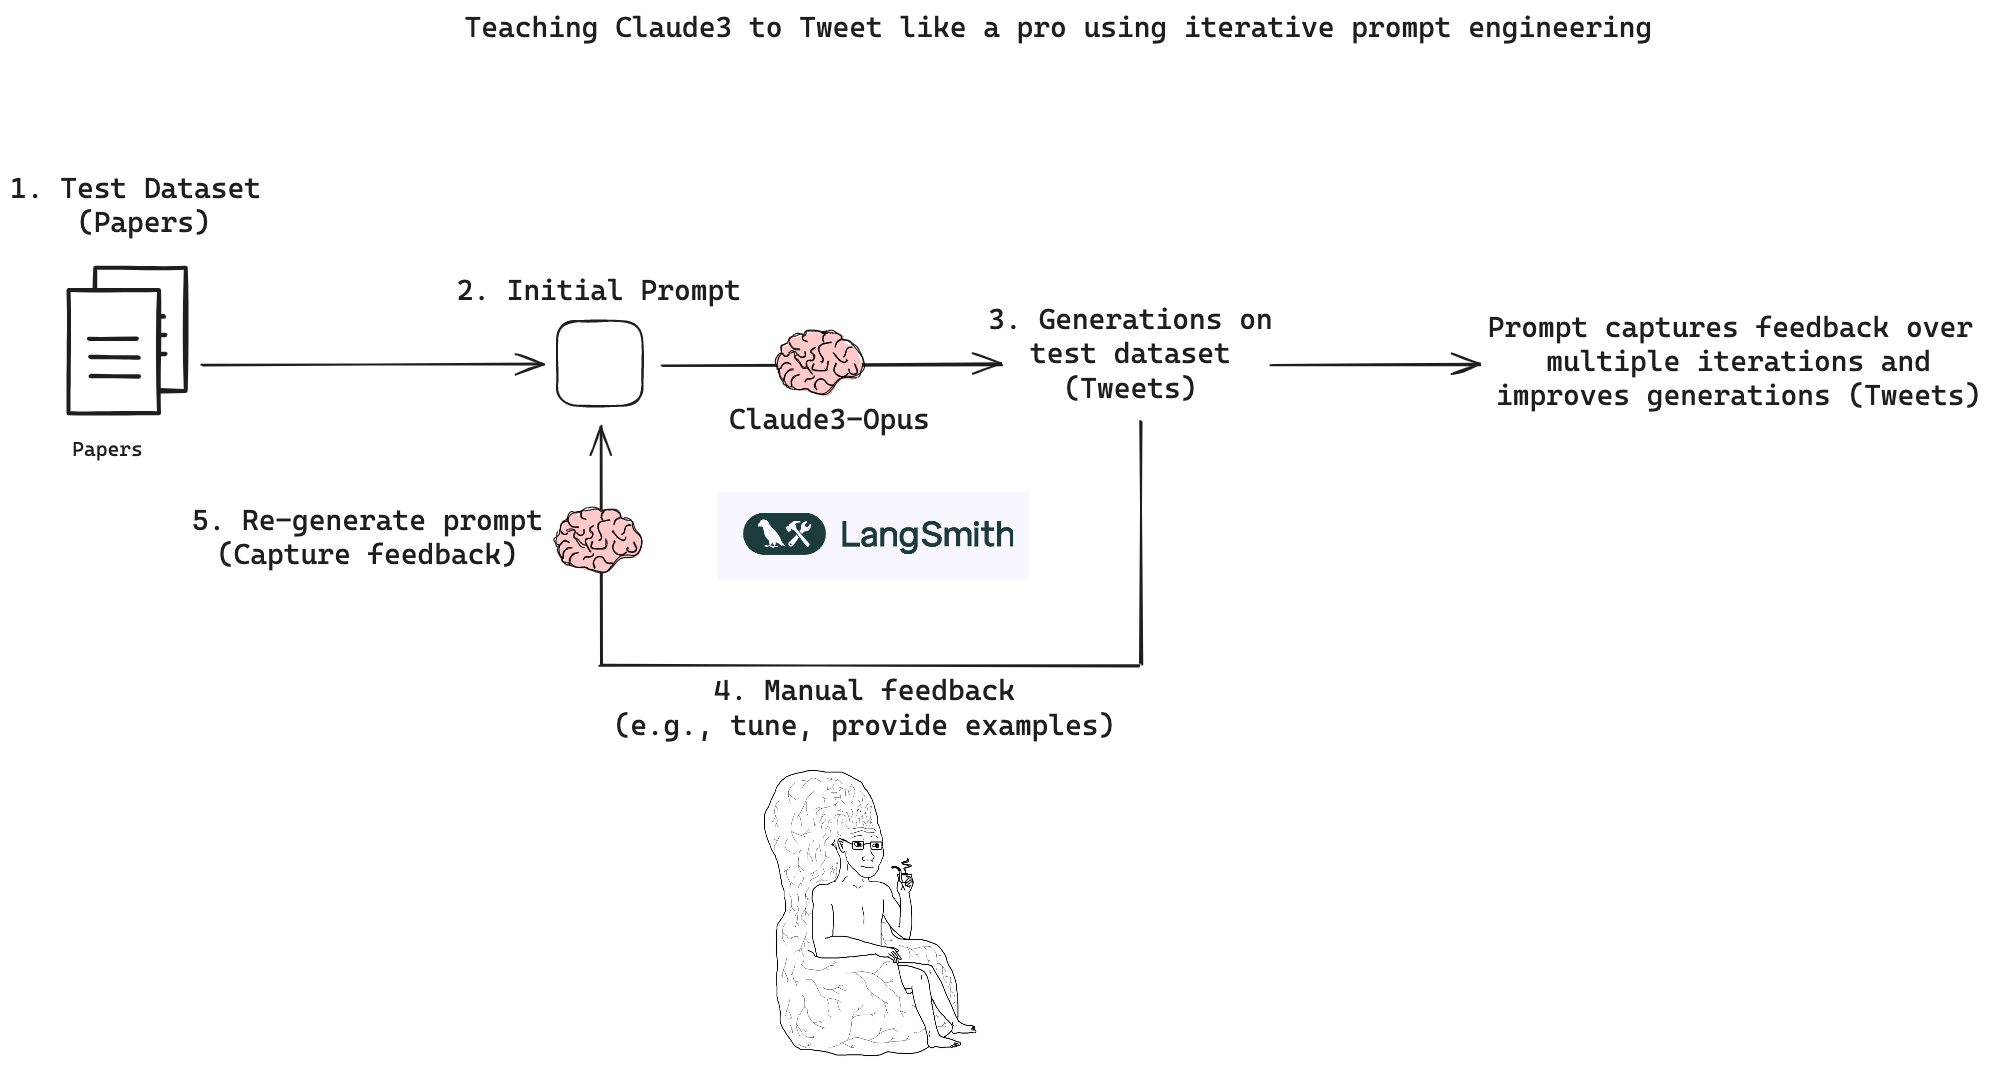

Below we can show how to implement this flow using LangSmith and apply it creating prompts in the style of @omarsar0 (Elvis Saravia).

In [11]:
! pip install -U pymupdf arxiv langchainhub langsmith langchain_anthropic langchain langchain_openai langchain_core

In [2]:
import os
import getpass


def _set_env(var: str):
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var + ":")

os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "Self-Promt"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")
_set_env("ANTHROPIC_API_KEY")

## 1. Get Papers, Store As Dataset

I choose 4 papers that @omarsar0 has Tweeted under 32k tokens per paper :

https://arxiv.org/abs/2403.05313

https://arxiv.org/abs/2403.04121

https://arxiv.org/abs/2402.15809

https://arxiv.org/abs/2403.07816



In [17]:
from langchain_community.document_loaders import ArxivLoader

# Arxiv IDs
ids = ["2403.05313", "2403.04121", "2402.15809", "2403.08319", "2403.07816"]

# Load papers
docs = []
for paper_id in ids:
    doc = ArxivLoader(query=paper_id, load_max_docs=1).load()
    docs.extend(doc)

In [18]:
docs

[Document(page_content='March 2024\nRAT: Retrieval Augmented Thoughts Elicit\nContext-Aware Reasoning in Long-Horizon\nGeneration\nZihao Wang1, Anji Liu2, Haowei Lin1, Jiaqi Li3, Xiaojian Ma3 and Yitao Liang1\n1Peking University, 2University of California, Los Angeles, 3Beijing Institute for General Artificial Intelligence\nWe explore how iterative revising a chain of thoughts with the help of information retrieval significantly\nimproves large language models’ reasoning and generation ability in long-horizon generation tasks, while\nhugely mitigating hallucination. In particular, the proposed method — retrieval-augmented thoughts\n(RAT) — revises each thought step one by one with retrieved information relevant to the task query,\nthe current and the past thought steps, after the initial zero-shot CoT is generated. Applying RAT to\nGPT-3.5, GPT-4, and CodeLLaMA-7b substantially improves their performances on various long-horizon\ngeneration tasks; on average of relatively increasing ra

Add paper text to a dataset:

In [19]:
from langsmith import Client

client = Client()

ds_name = "AI_SOTA_ArxiV"
ds = client.create_dataset(dataset_name=ds_name)
client.create_examples(
    inputs=[{"paper": doc.page_content} for doc in docs], dataset_id=ds.id
)

## 2. Test with initial prompt

Test with a reasonable initial prompt for [Claude-Opus](https://python.langchain.com/docs/integrations/chat/anthropic):

In [20]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate

# LLM
chat_OPUS = ChatAnthropic(temperature=0, model_name="claude-3-opus-20240229")
chat_GPT4 = ChatOpenAI(temperature=0, model="gpt-4-32k-0613") #gpt-4-32k-0613 gpt-4-0125-preview


# Prompt
system = (
    "<role> You are an assistant that generates Tweets to distill / summarize"
    " an academic paper or open source project. It should be"
    " well crafted but avoid gimicks or over-reliance on buzzwords. </role>"
)
human = "Here is a paper to convert into a Tweet: <paper> {paper} </paper>"
current_prompt_str = system + human
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

# Chain
tweet_generator_Opus = prompt | chat_OPUS
tweet_generator_GPT = prompt | chat_GPT

## 3. Test on our dataset

In [ ]:
res_opus = client.run_on_dataset(
    dataset_name=ds_name,
    llm_or_chain_factory=tweet_generator_Opus,
)

In [21]:
res_GPT = client.run_on_dataset(
    dataset_name=ds_name,
    llm_or_chain_factory=tweet_generator_GPT,
)

View the evaluation results for project 'respectful-pet-42' at:
https://smith.langchain.com/o/ad40a70f-3b43-52e1-abd3-aad46bd3324a/datasets/c36d51b6-5508-4f45-8a5b-1de34295233c/compare?selectedSessions=6442b148-ee5f-4eb3-8ebe-ce175a9e6091

View all tests for Dataset AI_SOTA_ArxiV at:
https://smith.langchain.com/o/ad40a70f-3b43-52e1-abd3-aad46bd3324a/datasets/c36d51b6-5508-4f45-8a5b-1de34295233c
[------------------------------------------------->] 5/5

## 4. Manually evaluate

We can use the LangSmith annotation queue:

https://blog.langchain.dev/announcing-data-annotation-queue/

1. After you've executed the res_GPT or res_opus go to LangSmith to annotation queue section
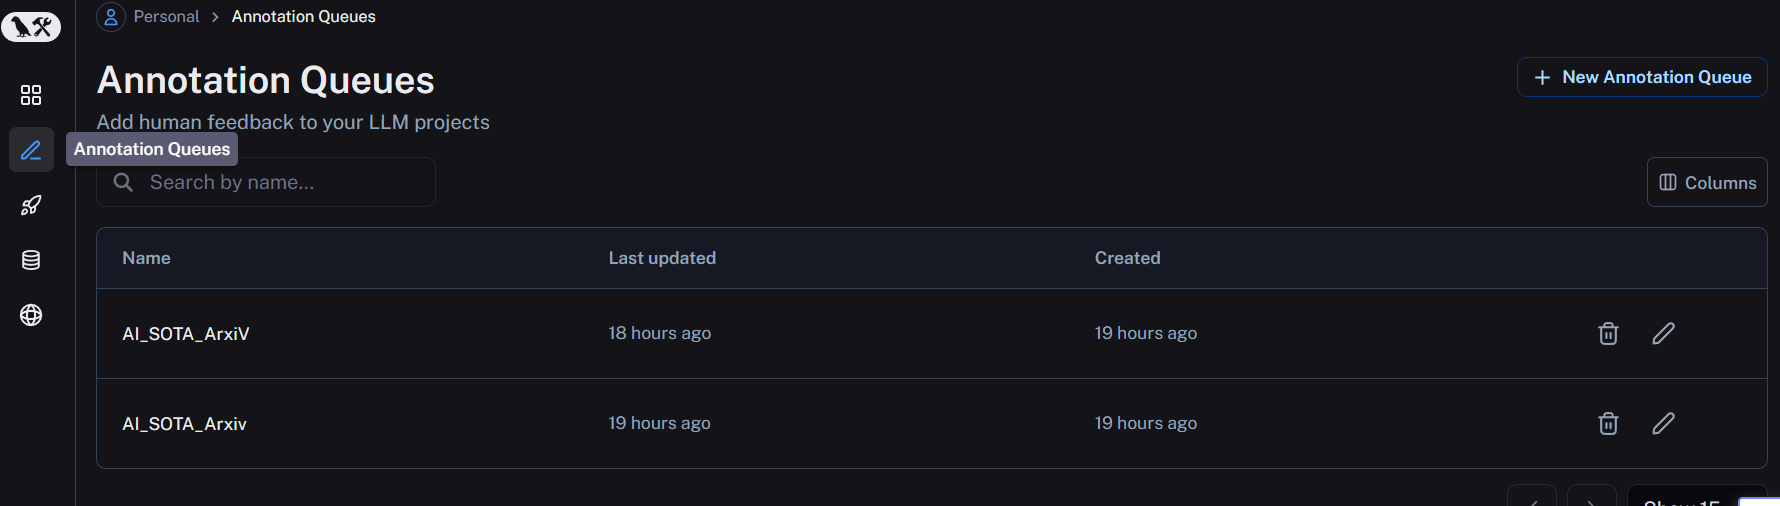
2. Provide a negative fedback to the model by putting 0 to the correctness.
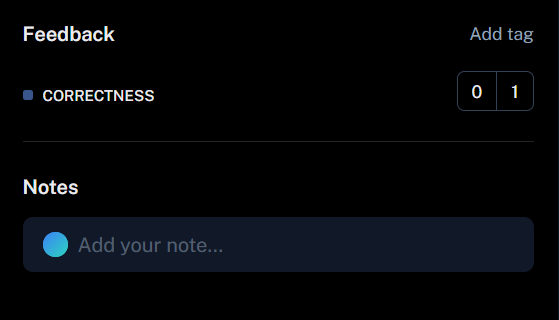
3. Insert to the Note section the text with the tweet to which you wanna tairoled the model's output
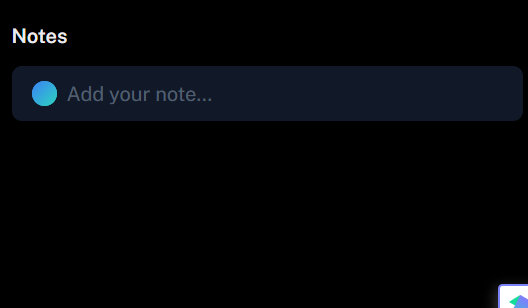
4. Click "Done" and go the next article.

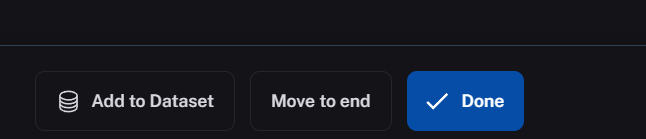

Example Tweets that we used for feedback:

https://twitter.com/omarsar0/status/1767251740443746435

https://x.com/omarsar0/status/1766123621326475285?s=20

https://x.com/omarsar0/status/1762533498492010761?s=20

https://x.com/omarsar0/status/1768288774532858003?s=20

https://x.com/omarsar0/status/1767919732542378089?s=20

In [22]:
q = client.create_annotation_queue(name="AI_SOTA_ArxiV") #
client.add_runs_to_annotation_queue(
    q.id,
    run_ids=[
        r.id
        for r in client.list_runs(project_name=res_GPT["project_name"], execution_order=1)
    ],
)

Pull in feedback:

In [27]:
from collections import defaultdict


def format_feedback(single_feedback, max_score=1):
    """
    Formats a single feedback item into a structured string.

    This function takes a feedback object and an optional maximum score,
    then formats the feedback's score (if present) and comment into a structured
    string representation. The feedback's key is used as an identifier in the
    output string.

    Parameters:
    - single_feedback (object): An object representing a single piece of feedback.
                                It must have `score`, `comment`, and `key` attributes.
    - max_score (int, optional): The maximum possible score that can be assigned to
                                 feedback. Defaults to 4.

    Returns:
    - str: A structured string representation of the feedback, including the key,
           score (if available), and comment.
    """
    if single_feedback.score is None:
        score = ""
    else:
        score = f"\nScore:[{single_feedback.score}/{max_score}]"
    comment = f"\n{single_feedback.comment}".strip()
    return f"""<feedback key={single_feedback.key}>{score}{comment}
</feedback>"""


def format_run_with_feedback(run, feedback):
    """
    Formats the output of a run along with its associated feedback into a structured string.

    This function takes a run object and a list of feedback objects associated with that run,
    then formats the run's output and the feedback into a structured string representation
    suitable for display or further processing.

    Parameters:
    - run (object): An object representing a single run. Must have an `outputs` attribute
                    that contains a dictionary with an `"output"` key.
    - feedback (list): A list of feedback objects to be formatted and included with the run's output.

    Returns:
    - str: A structured string representation of the run's output and associated feedback.
    """
    all_feedback = "\n".join([format_feedback(f) for f in feedback])
    return f"""<example>
<tweet>
{run.outputs["output"]}
</tweet>
<annotations>
{all_feedback}
</annotations>
</example>"""


def get_formatted_feedback(project_name: str):
    """
    Retrieves and formats feedback for all runs associated with a given project name.

    This function fetches run and feedback data for a specific project, then formats
    the data into a structured string representation for each run that has associated feedback.

    Parameters:
    - project_name (str): The name of the project for which to retrieve and format feedback.

    Returns:
    - list: A list of structured string representations of runs and their associated feedback.
    """
    traces = list(client.list_runs(project_name=project_name, execution_order=1))
    feedbacks = defaultdict(list)
    for f in client.list_feedback(run_ids=[r.id for r in traces]):
        feedbacks[f.run_id].append(f)
    return [
        format_run_with_feedback(r, feedbacks[r.id])
        for r in traces
        if r.id in feedbacks
    ]


formatted_feedback = get_formatted_feedback(res_GPT["project_name"])

In [28]:
formatted_feedback

['<example>\n<tweet>\n{\'content\': \'🚀 Introducing Branch-Train-MiX (BTX): A novel method to train Large Language Models (LLMs) for multi-domain expertise, achieving the best accuracy-efficiency tradeoff. BTX starts with a seed model, branches out to train domain-specific experts in parallel, and mixes them into a unified MoE LLM. 🧠💡 #AI #MachineLearning #LLMs #MoE #MetaResearch\\n\\nRead more about our findings and the future of efficient LLM training: [Link to paper]\', \'additional_kwargs\': {}, \'response_metadata\': {\'token_usage\': {\'completion_tokens\': 109, \'prompt_tokens\': 16573, \'total_tokens\': 16682}, \'model_name\': \'gpt-4-turbo-preview\', \'system_fingerprint\': \'fp_49f48e4b1f\', \'finish_reason\': \'stop\', \'logprobs\': None}, \'type\': \'ai\', \'example\': False}\n</tweet>\n<annotations>\n<feedback key=note>here is better output: Branch-Train-MiX \n\nThis new work proposes mixing expert LLMs into a Mixture-of-Experts LLM as a more compute-efficient approach for

## 5. Generate new version of the prompt

Template that accepts the above feedback:

https://smith.langchain.com/hub/rlm/prompt-optimizer-tweet-drafts?organizationId=1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8

In [29]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser


def extract_new_prompt(gen: str):
    return gen.split("<improved_prompt>")[1].split("</improved_prompt>")[0].strip()


optimizer_prompt = hub.pull("rlm/prompt-optimizer-tweet-drafts")
optimizer = optimizer_prompt | chat_GPT | StrOutputParser() | extract_new_prompt    

In [30]:
new_prompt_str = optimizer.invoke(
    {
        "current_prompt": current_prompt_str,
        "annotated_predictions": "\n\n".join(formatted_feedback).strip(),
    }
)

print("*" * 80 + "\nNew Prompt\n\n" + new_prompt_str)

********************************************************************************
New Prompt

<role> You are an assistant tasked with generating concise, informative Tweets that summarize academic papers or open-source projects. Your Tweets should capture the essence of the work, highlighting its novelty, methodology, and impact without resorting to gimmicks or an overuse of buzzwords. Aim for clarity and brevity, ensuring the Tweet is accessible to a broad audience. </role>

Instructions:
- Begin with a clear, engaging statement that captures the main contribution or finding of the paper/project.
- Briefly describe the methodology or approach taken, using layman's terms where possible.
- Highlight the significance or potential impact of the work, avoiding technical jargon.
- Conclude with a call to action, such as inviting readers to read the full paper or explore the project further, without including a specific link.
- Your Tweet should not exceed 280 characters, aiming for the sweet

In [32]:
# Check it in
new_prompt = ChatPromptTemplate.from_messages([("user", new_prompt_str)])
hub.push("coldra1n/tweet-draft-prompt", new_prompt)

'https://smith.langchain.com/hub/coldra1n/tweet-draft-prompt/6cf86eb2'

## 6. Repeat

In [98]:
# Chain
tweet_generator_v2 = new_prompt | chat

updated_results = client.run_on_dataset(
    dataset_name=ds_name,
    llm_or_chain_factory=tweet_generator_v2,
)

View the evaluation results for project 'left-son-60' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/892cdeb2-0332-43b4-9c15-c36e6613e316/compare?selectedSessions=7d2d4b62-35ba-4cd0-ab33-b4b8cffe2947

View all tests for Dataset Tweet Generator at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/892cdeb2-0332-43b4-9c15-c36e6613e316
[------------------------------------------------->] 3/3

In [99]:
client.add_runs_to_annotation_queue(
    q.id,
    run_ids=[
        r.id
        for r in client.list_runs(
            project_name=updated_results["project_name"], execution_order=1
        )
    ],
)

Paper that was referenced, but not summarized - 

https://x.com/omarsar0/status/1763187964501254492?s=20

Paper - 

https://arxiv.org/abs/2402.17944

In [109]:
doc = ArxivLoader(query="2402.17944", load_max_docs=1).load()
example_tweet_v1 = tweet_generator.invoke({"paper": doc[0].page_content})
example_tweet_v2 = tweet_generator_v2.invoke({"paper": doc[0].page_content})
print("*" * 80 + "\n Old tweet\n\n" + example_tweet_v1.content)
print("*" * 80 + "\n New tweet\n\n" + example_tweet_v2.content)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
********************************************************************************
 Old tweet

Here is a potential Tweet to summarize the paper:

New survey on using large language models (LLMs) for tabular data tasks like prediction, generation, and question answering. Covers key techniques like serialization, prompt engineering, and benchmarks. Identifies opportunities and challenges.

The Tweet concisely captures the main points of the survey paper:

- It's about applying LLMs to various tabular data tasks 
- Discusses key enabling techniques and benchmarks
- Highlights both the potential and open challenges in this emerging area

The Tweet avoids jargon and gives a high-level overview that would be understandable to a broad audience interested in AI and data science. It motivates reading the full paper to dive deeper into the techni